In [1]:
import pandas as pd
import numpy as np
import os
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly
import plotly.graph_objs as go
import seaborn as sns
from numpy.random import seed
from numpy.random import randn
from scipy.stats import mannwhitneyu
import math
import scipy
import warnings
warnings.filterwarnings('ignore')
seed(1)

pd.set_option('display.max_rows', 500)

import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

In [2]:
df = pd.read_csv('data.csv', sep=';')
df.head()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
0,143822.0,22,104.12,130068.80,8,756.09,31,0,36,10000.0,10000,196,0.0,2017-07-23,0.0,728319,320464,1
1,0.0,0,38151.93,46230.00,1492,38151.93,51,0,93,10000.0,10000,17,20000.0,2017-07-23,0.0,728321,320466,1
2,51356.0,2,3000.00,3000.00,8,3000.00,28,1,3,10000.0,10000,84,0.0,2017-07-23,0.0,728323,320467,1
3,0.0,0,22784.19,32103.52,913,22784.19,28,0,52,10000.0,10000,7,0.0,2017-07-23,0.0,728447,320533,1
4,12298.0,1,4942.95,4950.00,2883,4942.95,31,0,47,5000.0,5000,20,0.0,2017-07-23,0.0,728421,298598,1


# Предварительный анализ данных

In [3]:
# смотрим общую информацию
L = len(df)
Li = L
print(df.shape)
print(df.columns)
print(df.info())

(50001, 18)
Index(['closed_cred_sum', 'closed_creds', 'active_cred_sum_overdue',
       'active_cred_sum', 'active_cred_day_overdue', 'active_cred_max_overdue',
       'age', 'gender', 'region', 'first_loan', 'loan_cost_all',
       'first_days_quant', 'month_income', 'order_date', 'cost_all',
       'order_id', 'client_id', 'expert'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50001 entries, 0 to 50000
Data columns (total 18 columns):
closed_cred_sum            50001 non-null float64
closed_creds               50001 non-null int64
active_cred_sum_overdue    50001 non-null float64
active_cred_sum            50001 non-null float64
active_cred_day_overdue    50001 non-null int64
active_cred_max_overdue    50001 non-null float64
age                        50001 non-null int64
gender                     50001 non-null int64
region                     50001 non-null int64
first_loan                 49982 non-null float64
loan_cost_all              50001 non-null

В наличии имеются данные числовой природы (7 вещественного типа, 10 целочисленных 
                                           и один объект(требуется преобразование в дату/время)). При этом пол и целевая переменная уже преобразованы в бинарный тип (0/1). 

In [4]:
# преобразуем тип в дату-время
df['order_date']=pd.to_datetime(df['order_date'])

In [5]:
# смотрим основные характеристики
df.describe()

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,order_id,client_id,expert
count,5.000100e+04,50001.000000,5.000100e+04,5.000100e+04,50001.000000,5.000100e+04,50001.000000,50001.000000,50001.000000,49982.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000,50001.000000
mean,1.865780e+05,7.974001,5.217919e+04,1.964205e+05,722.563769,3.776984e+04,35.018900,0.462691,28.825083,7751.682606,6703.681926,23.954561,24943.402642,1233.828788,734747.279874,290563.956781,0.749265
std,5.057408e+05,13.933307,2.537311e+05,4.365213e+05,1371.656677,1.703992e+05,11.235206,0.498611,29.726162,5310.782009,4610.529844,36.670176,20652.768218,4556.672041,26254.078989,74592.964584,0.433441
min,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,18.000000,0.000000,0.000000,2000.000000,0.000000,0.000000,0.000000,0.000000,695828.000000,109.000000,0.000000
25%,5.502000e+03,1.000000,0.000000e+00,1.467400e+04,0.000000,4.870800e+02,27.000000,0.000000,0.000000,5000.000000,3000.000000,10.000000,0.000000,0.000000,715042.000000,294858.000000,0.000000
50%,4.287400e+04,4.000000,5.000000e+03,5.703022e+04,64.000000,6.765660e+03,32.000000,0.000000,25.000000,7000.000000,7000.000000,20.000000,25000.000000,0.000000,734707.000000,316156.000000,1.000000
75%,1.740713e+05,9.000000,3.157990e+04,1.972360e+05,923.000000,2.449949e+04,41.000000,1.000000,52.000000,10000.000000,10000.000000,20.000000,35000.000000,0.000000,749477.000000,330172.000000,1.000000
max,4.457421e+07,563.000000,3.303100e+07,2.273166e+07,21927.000000,2.170166e+07,99.000000,1.000000,99.000000,100000.000000,100000.000000,336.000000,550000.000000,238770.420000,840692.000000,393528.000000,1.000000


Text(0.5, 1.0, 'Распределение одобрения кредитов')

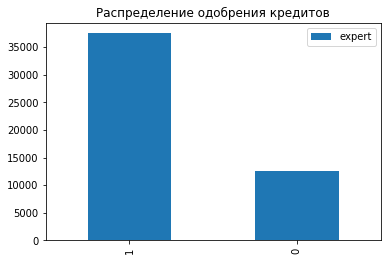

In [6]:
# Целевая переменная
df['expert'].value_counts().plot(kind='bar', label='expert')
plt.legend()
plt.title('Распределение одобрения кредитов')

одобряется только четверть всех заявок

In [7]:
# посмотрим какие характеристики в среднем у тех, кто получил одобрение по кредиту, и кто нет
print('expert\t\t\t (yes) 0 (', len(df[df['expert'] == 0]) ,')\t (no) 1 (', len(df[df['expert'] == 1]),')')
for i in range(len(df.drop(['order_date'], axis = 1).columns)):
    print(list(df.drop(['order_date'], axis = 1).columns)[i] + [math.ceil((max([len(x) for x in(list(df.columns))]) - len(y) + 1) / 8) for y in(list(df.columns))][i] * '\t', 
          '{0:.2f}'.format(list(df[df['expert'] == 0].mean())[i]),
          '\t\t', '{0:.2f}'.format(list(df[df['expert'] == 1].mean())[i]))

expert			 (yes) 0 ( 12537 )	 (no) 1 ( 37464 )
closed_cred_sum		 275654.66 		 156769.24
closed_creds		 12.22 		 6.55
active_cred_sum_overdue	 24873.14 		 61316.92
active_cred_sum		 243086.54 		 180804.07
active_cred_day_overdue	 304.66 		 862.41
active_cred_max_overdue	 22659.21 		 42826.48
age			 39.42 		 33.54
gender			 0.44 		 0.47
region			 24.17 		 30.38
first_loan		 8128.43 		 7625.62
loan_cost_all		 3974.36 		 7617.02
first_days_quant	 16.85 		 26.33
month_income		 33509.66 		 22076.78
cost_all		 4920.85 		 0.00
order_id		 729169.18 		 736613.94
client_id		 246173.93 		 305418.69
expert		 0.00 		 1.00


Предварительный анализ показывает, что у клиентов, которым кредит был одобрен, на уровне средних значений наблюдаются более благоприятные характеристики: большее количество успешно закрытых кредитов (12.22 против 6.55, по сумме 275654.66 против 156769.24), меньшая просроченная задолженность (24873.14 против 61316.92) и просрочка в днях (304.66 против 862.41), более высокий месячный доход (33509.66 против 22076.78). Такая разница между значениями этих ключевых параметров между двумя группами выглядит вполне логично. Также одобренные заявители старше (39.42 против 33.54, что возможно сигнализирует о более ответственном подходе к денежному вопросу) и имеют большую сумму активных кредитов (243086.54  против 180804.07). Одобренные кредиты имеют меньшую продолжительность (16.85 против 26.33)

In [8]:
# посмотрим ещё раз на различия в ключевых параметрах
df.groupby(['expert'])[['closed_cred_sum','closed_creds', 'active_cred_sum_overdue', 'active_cred_day_overdue', 
                        'age', 'first_days_quant', 'month_income']].agg([np.mean, np.std]).applymap("{:.0f}".format)

closed_cred_sum         closed_creds     active_cred_sum_overdue  \
                  mean     std         mean std                    mean   
expert                                                                    
0               275655  662746           12  19                   24873   
1               156769  436861            7  12                   61317   

               active_cred_day_overdue        age     first_days_quant      \
           std                    mean   std mean std             mean std   
expert                                                                       
0       120658                     305   868   39  13               17   8   
1       284112                     862  1477   34  10               26  42   

       month_income         
               mean    std  
expert                      
0             33510  18529  
1             22077  20533

# Фильтрация данных

In [9]:
# Посмотрим, есть ли незаполненные данные
A=[]
for x in df.columns:
    A.append(len(df[df[x].isnull()]))
print(A)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0, 0, 0, 0, 0, 0]


Пропуски значений есть только в десятом столбце 'first_loan' (19 пропусков), посмотрим на строки с пропусками

In [10]:
df[df['first_loan'].isnull()]

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,order_id,client_id,expert
184,2722669.00,59,0.00,891500.00,0,8956.61,57,0,40,NaN,10000,10,87000.0,2017-07-25,0.0,730831,183863,1
7150,765963.00,8,589946.45,1025000.00,4418,259317.43,53,0,40,NaN,2000,20,40000.0,2017-07-01,0.0,702433,306898,1
8848,23500.00,4,12594.87,287250.00,282,8500.00,22,0,40,NaN,2000,20,42000.0,2017-07-03,0.0,705194,214622,1
13176,24000.00,3,2230.20,3000.00,5,2230.20,22,0,0,NaN,2000,20,25000.0,2017-07-08,0.0,711678,197369,1
13461,934734.29,97,0.00,307449.02,0,764.82,25,1,0,NaN,2500,20,50000.0,2017-07-08,3590.0,712046,231691,0
13581,0.00,0,15000.00,15000.00,137,15000.00,18,0,78,NaN,2000,20,30000.0,2017-07-08,0.0,712179,227008,1
24461,1653801.90,117,255644.29,672187.99,2744,60076.09,36,1,4,NaN,2000,20,40000.0,2017-07-24,0.0,729540,236614,1
30659,5337.00,1,37124.07,38567.00,1435,37124.07,25,0,65,NaN,2000,20,25000.0,2017-07-30,0.0,738690,149577,1
31243,62709.00,7,50641.35,67496.00,3579,45027.00,36,0,78,NaN,2000,20,26000.0,2017-07-31,0.0,740962,309289,1
32363,129000.00,4,73506.93,83500.00,4801,47506.93,31,0,78,NaN,1000,23,45000.0,2017-07-31,1501.4,741054,324256,0


In [11]:
# с неодобренными кредитами разобраться легко, 
# почти в 100% случаев в этой графе проставляется то же значение, что было указано в заявке
# будем считать, что это регламент внесения данных
print('доля случаев, когда записи в полях first_loan и loan_cost_all совпадают для неодобренных кредитов: ', 
      len(df[(df['first_loan'] == df['loan_cost_all']) & (df['expert'] == 1)])/len(df[df['expert'] == 1]))

доля случаев, когда записи в полях first_loan и loan_cost_all совпадают для неодобренных кредитов:  0.9971172325432415


In [12]:
# к сожалению, нельзя то же самое сказать для одобренных кредитов
len(df[(df['first_loan'] == df['loan_cost_all']) & (df['expert'] == 0)])/len(df[df['expert'] == 0])

0.30198612108159845

In [13]:
# более того заявленная и одобренная сумма не пропорциональны друг другу
scipy.stats.pearsonr(df[(df['first_loan'].notnull()) & (df['expert'] == 0)]['first_loan'],
                      df[(df['first_loan'].notnull()) & (df['expert'] == 0)]['loan_cost_all'])

(0.5854567926061959, 0.0)

In [14]:
# хоть пропорциональной зависимости между одобренной и заявленной суммы нет, связь между ними имеется, 
# поэтому посчитаем разумным заменить отсутствующие значение в таких строках на среднюю долю одобренной суммы от заявленной
df['first_loan'][df[(df['first_loan'].isnull()) & (df['expert'] == 1)].index] = df['loan_cost_all'][df[(df['first_loan'].isnull()) & (df['expert'] == 1)].index]
df['first_loan'][df[(df['first_loan'].isnull()) & (df['expert'] == 0)].index] = df['first_loan'].mean() / df['loan_cost_all'].mean() * df['loan_cost_all'][df[(df['first_loan'].isnull()) & (df['expert'] == 0)].index]

In [15]:
# посмотрим, есть ли дублирующиеся записи
len(df) - len(df['order_id'].unique())

7144

In [16]:
# имеется много записей с дублирующимися заявками
# оставим только первую строчку среди дублирующихся
df = df.groupby(['order_id']).first().reset_index()

In [17]:
# много ли строк с совпадающим клиентом
len(df) - len(df['client_id'].unique())

2698

In [18]:
# посмотрим, есть ли что-нибудь интересное в случаях, когда клиент подаёт не первую заявку
df_custom = df.copy()
df_custom['attempt'] = df_custom['client_id']
# добавим поле с данными о количестве заявок от каждого клиента
for i in range(len(df_custom)):
    df_custom.loc[i, 'attempt'] = df_custom[(df_custom['client_id']==df_custom['client_id'][i])]['attempt'].count()
# оставим случаи, когда заявок больше одной
df_custom = df_custom[df_custom['attempt'] > 1]
df_custom

,order_id,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,order_date,cost_all,client_id,expert,attempt
14,695843,281543.04,28,0.00,132001.00,0,0.0,47,0,8,10000.0,2000,19,60000.0,2017-06-26,2828.40,303616,0,2
16,695845,50990.00,7,0.00,45596.32,0,0.0,24,1,49,7000.0,7000,10,35000.0,2017-06-26,0.00,303618,1,2
26,695859,46300.00,5,30000.00,32000.00,615,9000.0,31,1,65,7000.0,7000,10,35000.0,2017-06-26,0.00,232537,1,2
27,695860,66249.00,10,0.00,75764.42,0,0.0,33,1,52,4000.0,4000,10,25000.0,2017-06-26,4872.00,291192,0,2
30,695865,640579.00,43,8845.32,220163.72,519,6668.0,30,1,0,20000.0,2000,20,30000.0,2017-06-26,2872.00,281101,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42713,838486,220000.00,31,55673.37,158310.06,1504,31157.0,64,1,0,2000.0,2000,15,10000.0,2017-09-25,2654.00,224645,0,3
42720,838566,220000.00,31,55673.37,158310.06,1504,31157.0,64,1,0,2000.0,2000,15,10000.0,2017-09-25,9187.28,224645,0,3
42735,838827,212954.96,16,43723.24,191078.10,266,15000.0,25,0,71,5000.0,5000,10,35000.0,2017-09-25,0.00,391511,1,2
42798,840027,8870.00,5,0.00,15305.66,0,0.0,30,0,0,2000.0,2000,7,35000.0,2017-09-25,2392.40,246694,0,2


In [19]:
# посмотрим распределение количества заявок от одного клиента
df_custom['attempt'].value_counts()

2    4388
3     603
4      76
5      35
6      12
8       8
Name: attempt, dtype: int64

In [20]:
#df_custom = df_custom.sort_values(by='order_date', ascending=True).reset_index(drop=True)
# сгруппируем по количеству заявок
df_custom1 = df_custom.groupby(['attempt']).mean().reset_index()
# добавим фичу: была отклонена первая заявка или нет
df_custom2 = df_custom.groupby(['attempt', 'order_date']).first().reset_index()
df_custom2['first_att'] = df_custom2['expert']
df_custom2 = df_custom2[['first_att', 'client_id']]

In [21]:
df_custom = df_custom.merge(df_custom2)

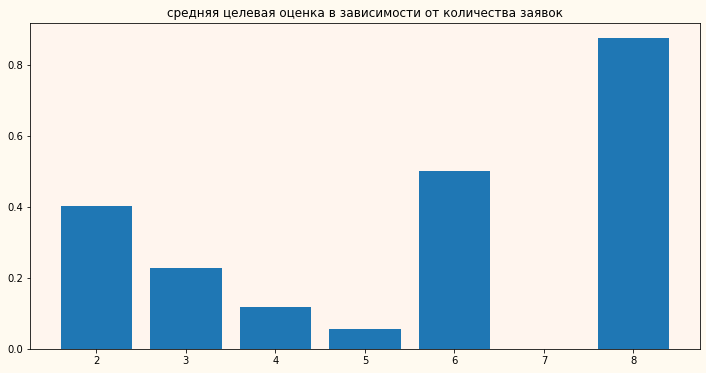

In [22]:
fig, ax = plt.subplots()
ax.bar(df_custom1['attempt'], df_custom1['expert'])
ax.set_facecolor('seashell')
ax.set_title('средняя целевая оценка в зависимости от количества заявок')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.show()

In [23]:
# сложно сказать, как именно влияет количество заявок на одобрение. По крайней мере при количестве заявок менее 6
# наблюдается рост одобрения. Однако непоянтно, правдоподобно ли то, что клиенты подают много успешных заявок всего в течение 
# трёх месяцев
pd.crosstab(df_custom['first_att'], df_custom['expert'])

expert,0,1
first_att,,
0,397,32
1,16,98


In [24]:
# выглядит подозрительно. почти всегда за отказом следуют отказы, а за одобрением - одобрения.
# судя по всему в таблице есть строки, где хоть номер заявки и не дублируется, но по сути запись одинаковая:
# тот же клиент и тот же день подачи заявки. Исключим такие записи
df.groupby(['order_date','client_id']).count()

order_id  closed_cred_sum  closed_creds  \
order_date client_id                                            
2017-06-26 2698              1                1             1   
           3296              3                3             3   
           4782              2                2             2   
           6052              1                1             1   
           13737             1                1             1   
...                        ...              ...           ...   
2017-09-25 393509            1                1             1   
           393510            1                1             1   
           393511            1                1             1   
           393527            1                1             1   
           393528            1                1             1   

                      active_cred_sum_overdue  active_cred_sum  \
order_date client_id                                             
2017-06-26 2698                             1                1   
           3296                             3                3   
           4782                             2                2   
           6052                             1                1   
           13737                            1                1   
...                                       ...              ...   
2017-09-25 393509                           1                1   
           393510                           1                1   
           393511                           1                1   
           393527                           1                1   
           393528                           1                1   

                      active_cred_day_overdue  active_cred_max_overdue  age  \
order_date client_id                                                          
2017-06-26 2698                             1                        1    1   
           3296                             3                        3    3   
           4782                             2                        2    2   
           6052                             1                        1    1   
           13737                            1                        1    1   
...                                       ...                      ...  ...   
2017-09-25 393509                           1                        1    1   
           393510                           1                        1    1   
           393511                           1                        1    1   
           393527                           1                        1    1   
           393528                           1                        1    1   

                      gender  region  first_loan  loan_cost_all  \
order_date client_id                                              
2017-06-26 2698            1       1           1              1   
           3296            3       3           3              3   
           4782            2       2           2              2   
           6052            1       1           1              1   
           13737           1       1           1              1   
...                      ...     ...         ...            ...   
2017-09-25 393509          1       1           1              1   
           393510          1       1           1              1   
           393511          1       1           1              1   
           393527          1       1           1              1   
           393528          1       1           1              1   

                      first_days_quant  month_income  cost_all  expert  
order_date client_id                                                    
2017-06-26 2698                      1             1         1       1  
           3296                      3             3         3       3  
           4782                      2             2         2       2  
           6052                      1             1

In [25]:
df = df.groupby(['order_date','client_id']).first().reset_index()

In [26]:
# период, за который предоставлены данные - 3 месяца
print(df['order_date'].min())
print(df['order_date'].max())
print(len(df['order_date'].unique()))

2017-06-26 00:00:00
2017-09-25 00:00:00
80


(array([736511., 736525., 736542., 736556., 736573., 736587.]),
 <a list of 6 Text xticklabel objects>)

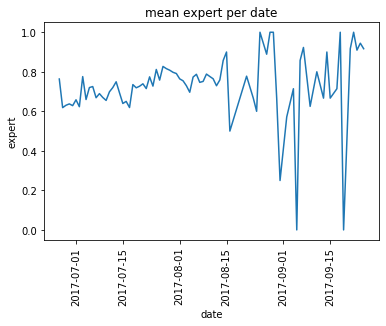

In [27]:
# посмотрим, как менялся процент одобренных заявок с течением времени
df_time = df.copy()
df_time = df_time.groupby(['order_date']).mean().reset_index()
plt.plot(df_time['order_date'],df_time['expert'])
plt.xlabel('date')
plt.ylabel('expert')
plt.title('mean expert per date')
plt.xticks(rotation=90)

In [28]:
# наблюдаются экстремальные значение в целевой переменной в некоторые дни
print(df_time[df_time['expert'] == 0]['order_date'])
print(df_time[df_time['expert'] == 1]['order_date'])

64   2017-09-05
74   2017-09-19
Name: order_date, dtype: datetime64[ns]
56   2017-08-25
58   2017-08-28
59   2017-08-29
73   2017-09-18
76   2017-09-22
Name: order_date, dtype: datetime64[ns]


In [29]:
# посмотрим, что было в эти дни
df[df['order_date'] == df_time['order_date'][56]]

,order_date,client_id,order_id,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,region,first_loan,loan_cost_all,first_days_quant,month_income,cost_all,expert
41040,2017-08-25,350118,778639,31980.0,1,34443.31,42000.0,1035,13326.92,46,0,3,7000.0,7000,12,35000.0,0.0,1


In [30]:
# скачки в целевой переменной связано с малым количеством обработанных заявок в эти дни (одна-две), 
# по крайней мере на поверхности нет причин копать здесь глубже, не видно, чтобы значение целевого параметра 
# имело чётко выраженную тенденцию с течением времени

In [31]:
# после рассмотрения вышеизложенного рассмотрения данных
# выкинем столбцы, которые не понадобятся для прогноза целевой переменной
# очевидно, нам не понадобится id заявки и клиента
df = df.drop(['client_id'], axis = 1)
df = df.drop(['order_id'], axis = 1)
# одобренная сумма кредита и сумма выплат по одобренному кредиту 
# становятся известны постфактум и для прогноза целевой переменной не годятся
df = df.drop(['cost_all'], axis = 1)
df = df.drop(['loan_cost_all'], axis = 1)
# дата подачи помогла нам отфильтровать данные, но для прогноза роли не играет
df = df.drop(['order_date'], axis = 1)
print('дропнуто ', L - len(df), ' строк из ', Li)
L = len(df)
Li = L

дропнуто  7721  строк из  50001


Посмотрим на выбросы

In [32]:
# выделим числовые признаки
num_feat = ['closed_cred_sum', 'closed_creds', 'active_cred_sum_overdue',
       'active_cred_sum', 'active_cred_day_overdue', 'active_cred_max_overdue',
       'age', 'first_loan', 'first_days_quant', 'month_income']

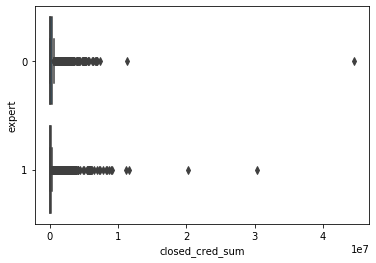

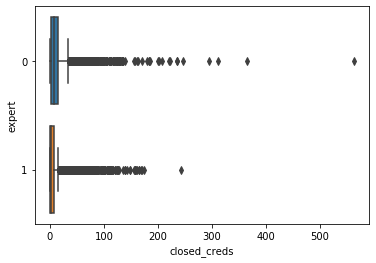

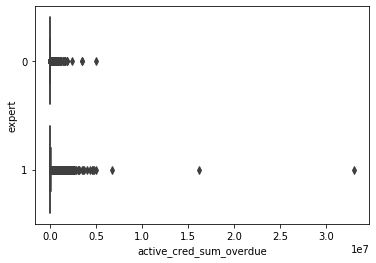

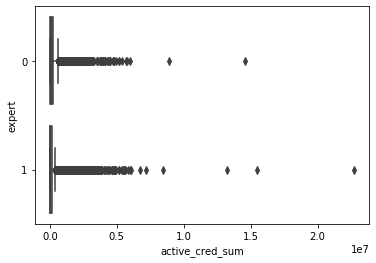

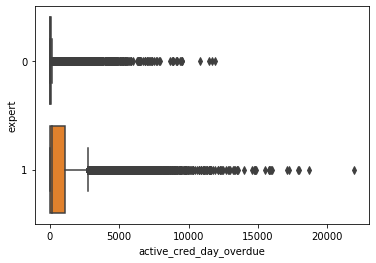

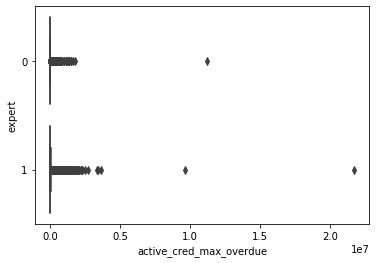

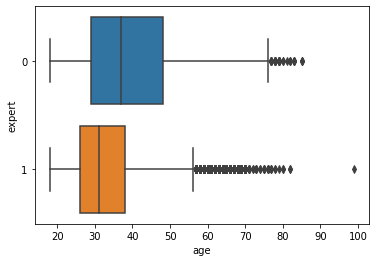

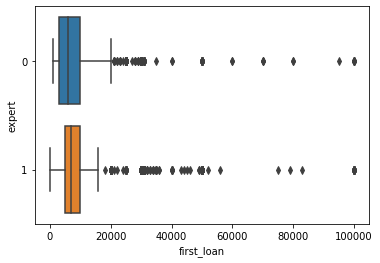

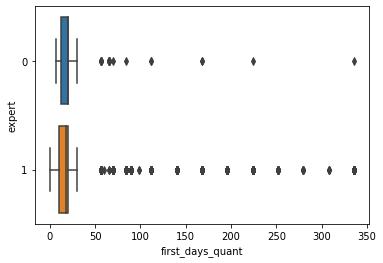

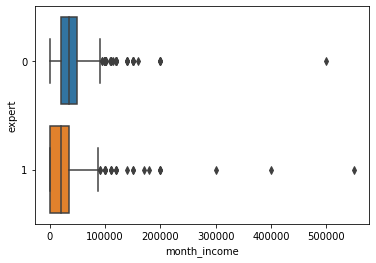

In [33]:
for x in num_feat:
    plt.figure()
    sns.boxplot(x=x, y='expert', data=df, orient="h")

In [34]:
# в данных очень много выбросов. Выкинем значения, лежащие за пределами +/- 3std
for x in num_feat:
    print('переменная '+x+'\n',
          'среднее: ', df[x].mean(),
         '\n медиана: ', df[x].median(),
         '\n std: ', df[x].std())
    df = df[(df[x] >= df[x].mean() - 3 * df[x].std()) & (df[x] <= df[x].mean() + 3 * df[x].std())]
    print('дропнуто ', L - len(df),' строк\n')
    L = len(df)
print('всего дропнуто строк ', Li - L ,' из ', Li)

переменная closed_cred_sum
 среднее:  179672.28805297945 
 медиана:  39648.5 
 std:  510592.4344596242
дропнуто  562  строк

переменная closed_creds
 среднее:  7.285008869073302 
 медиана:  3.0 
 std:  11.788220035872026
дропнуто  872  строк

переменная active_cred_sum_overdue
 среднее:  46189.027456299096 
 медиана:  5000.0 
 std:  235571.69547985442
дропнуто  337  строк

переменная active_cred_sum
 среднее:  153129.10654817626 
 медиана:  49874.0 
 std:  303048.70222090266
дропнуто  705  строк

переменная active_cred_day_overdue
 среднее:  669.304718118782 
 медиана:  57.0 
 std:  1232.8150926073058
дропнуто  901  строк

переменная active_cred_max_overdue
 среднее:  24654.830899673558 
 медиана:  5600.0 
 std:  58024.762275646215
дропнуто  913  строк

переменная age
 среднее:  34.51989997367728 
 медиана:  32.0 
 std:  11.323142120921283
дропнуто  263  строк

переменная first_loan
 среднее:  7591.888003233012 
 медиана:  7000.0 
 std:  5302.621533282677
дропнуто  713  строк

переменн

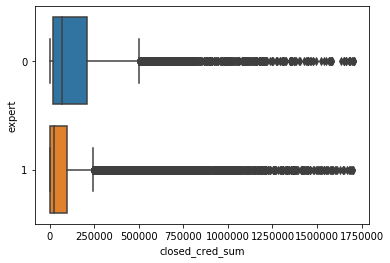

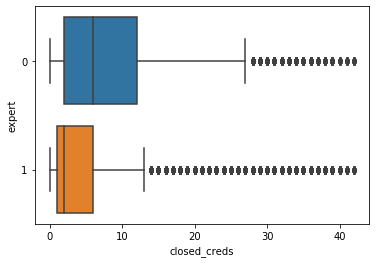

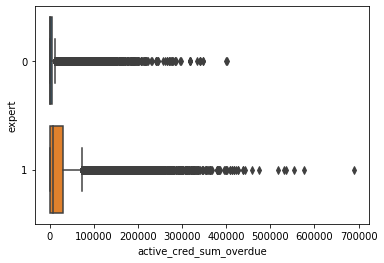

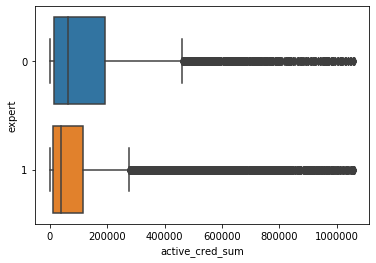

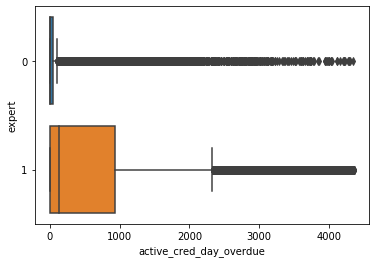

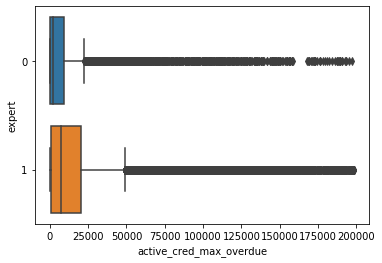

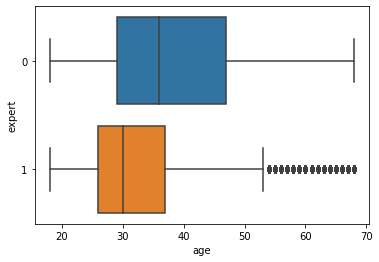

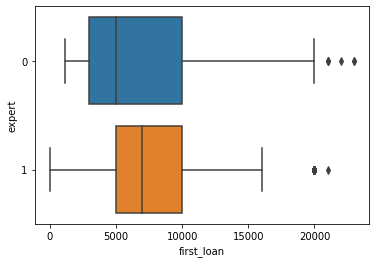

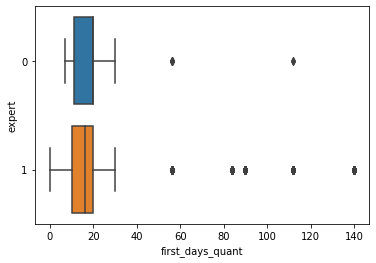

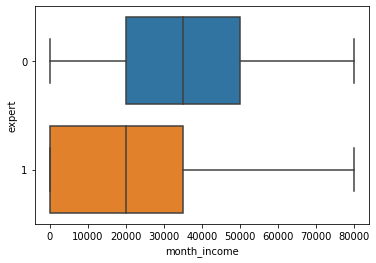

In [35]:
# Визуализируем коробки ещё раз
for x in num_feat:
    plt.figure()
    sns.boxplot(x=x, y='expert', data=df, orient="h") 

не везде ситуация с выбросами стала лучше из-за очевидно не Гауссовых распределений значений признаков. Также по целевой переменной -
 без сюрпризов. Больше одобрений там, где выше доход и меньше просрочек и кредитная нагрузка.

# Визуальный анализ данных

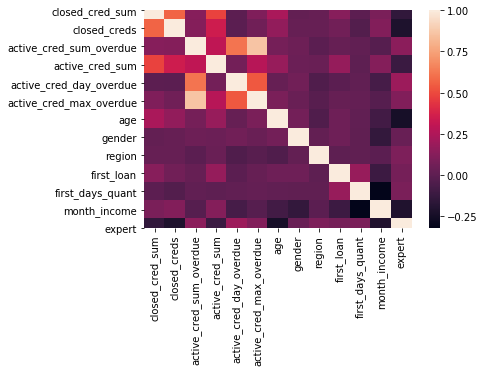

In [36]:
# посмотрим, есть ли среди признаков скореллированные
sns.heatmap(df.corr())

In [37]:
scipy.stats.pearsonr(df['active_cred_sum_overdue'], df['active_cred_max_overdue'])

(0.8644461669127814, 0.0)

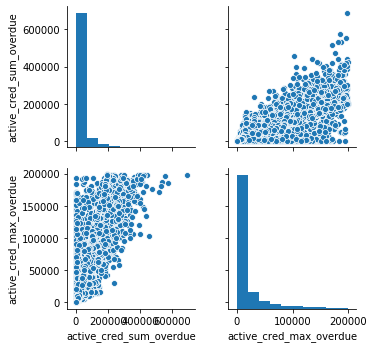

In [38]:
sns_plot = sns.pairplot(df[['active_cred_sum_overdue', 'active_cred_max_overdue']])

Заметим, что наблюдается высокая корреляция между текущей и максимальной просроченной задолженностью и текущим её значением.
Это говорит о том, что в случае возникновения задолженности, ситуация, которая сложилась у клиента, во многих случаях
во всяком случае не улучшается. То есть, если задолженность возникла, то она растёт и в большинстве случаев максимум достигается в момент подачи заявки на новый кредит. Вполне возможно, клиенты пытаются погасить старые долги за счёт получения новых кредитов. Видимо наличие большой просроченной задолженности может быть одним из ключевых признаков, так как выдавать кредит без берспективы его возврата бессмысленно

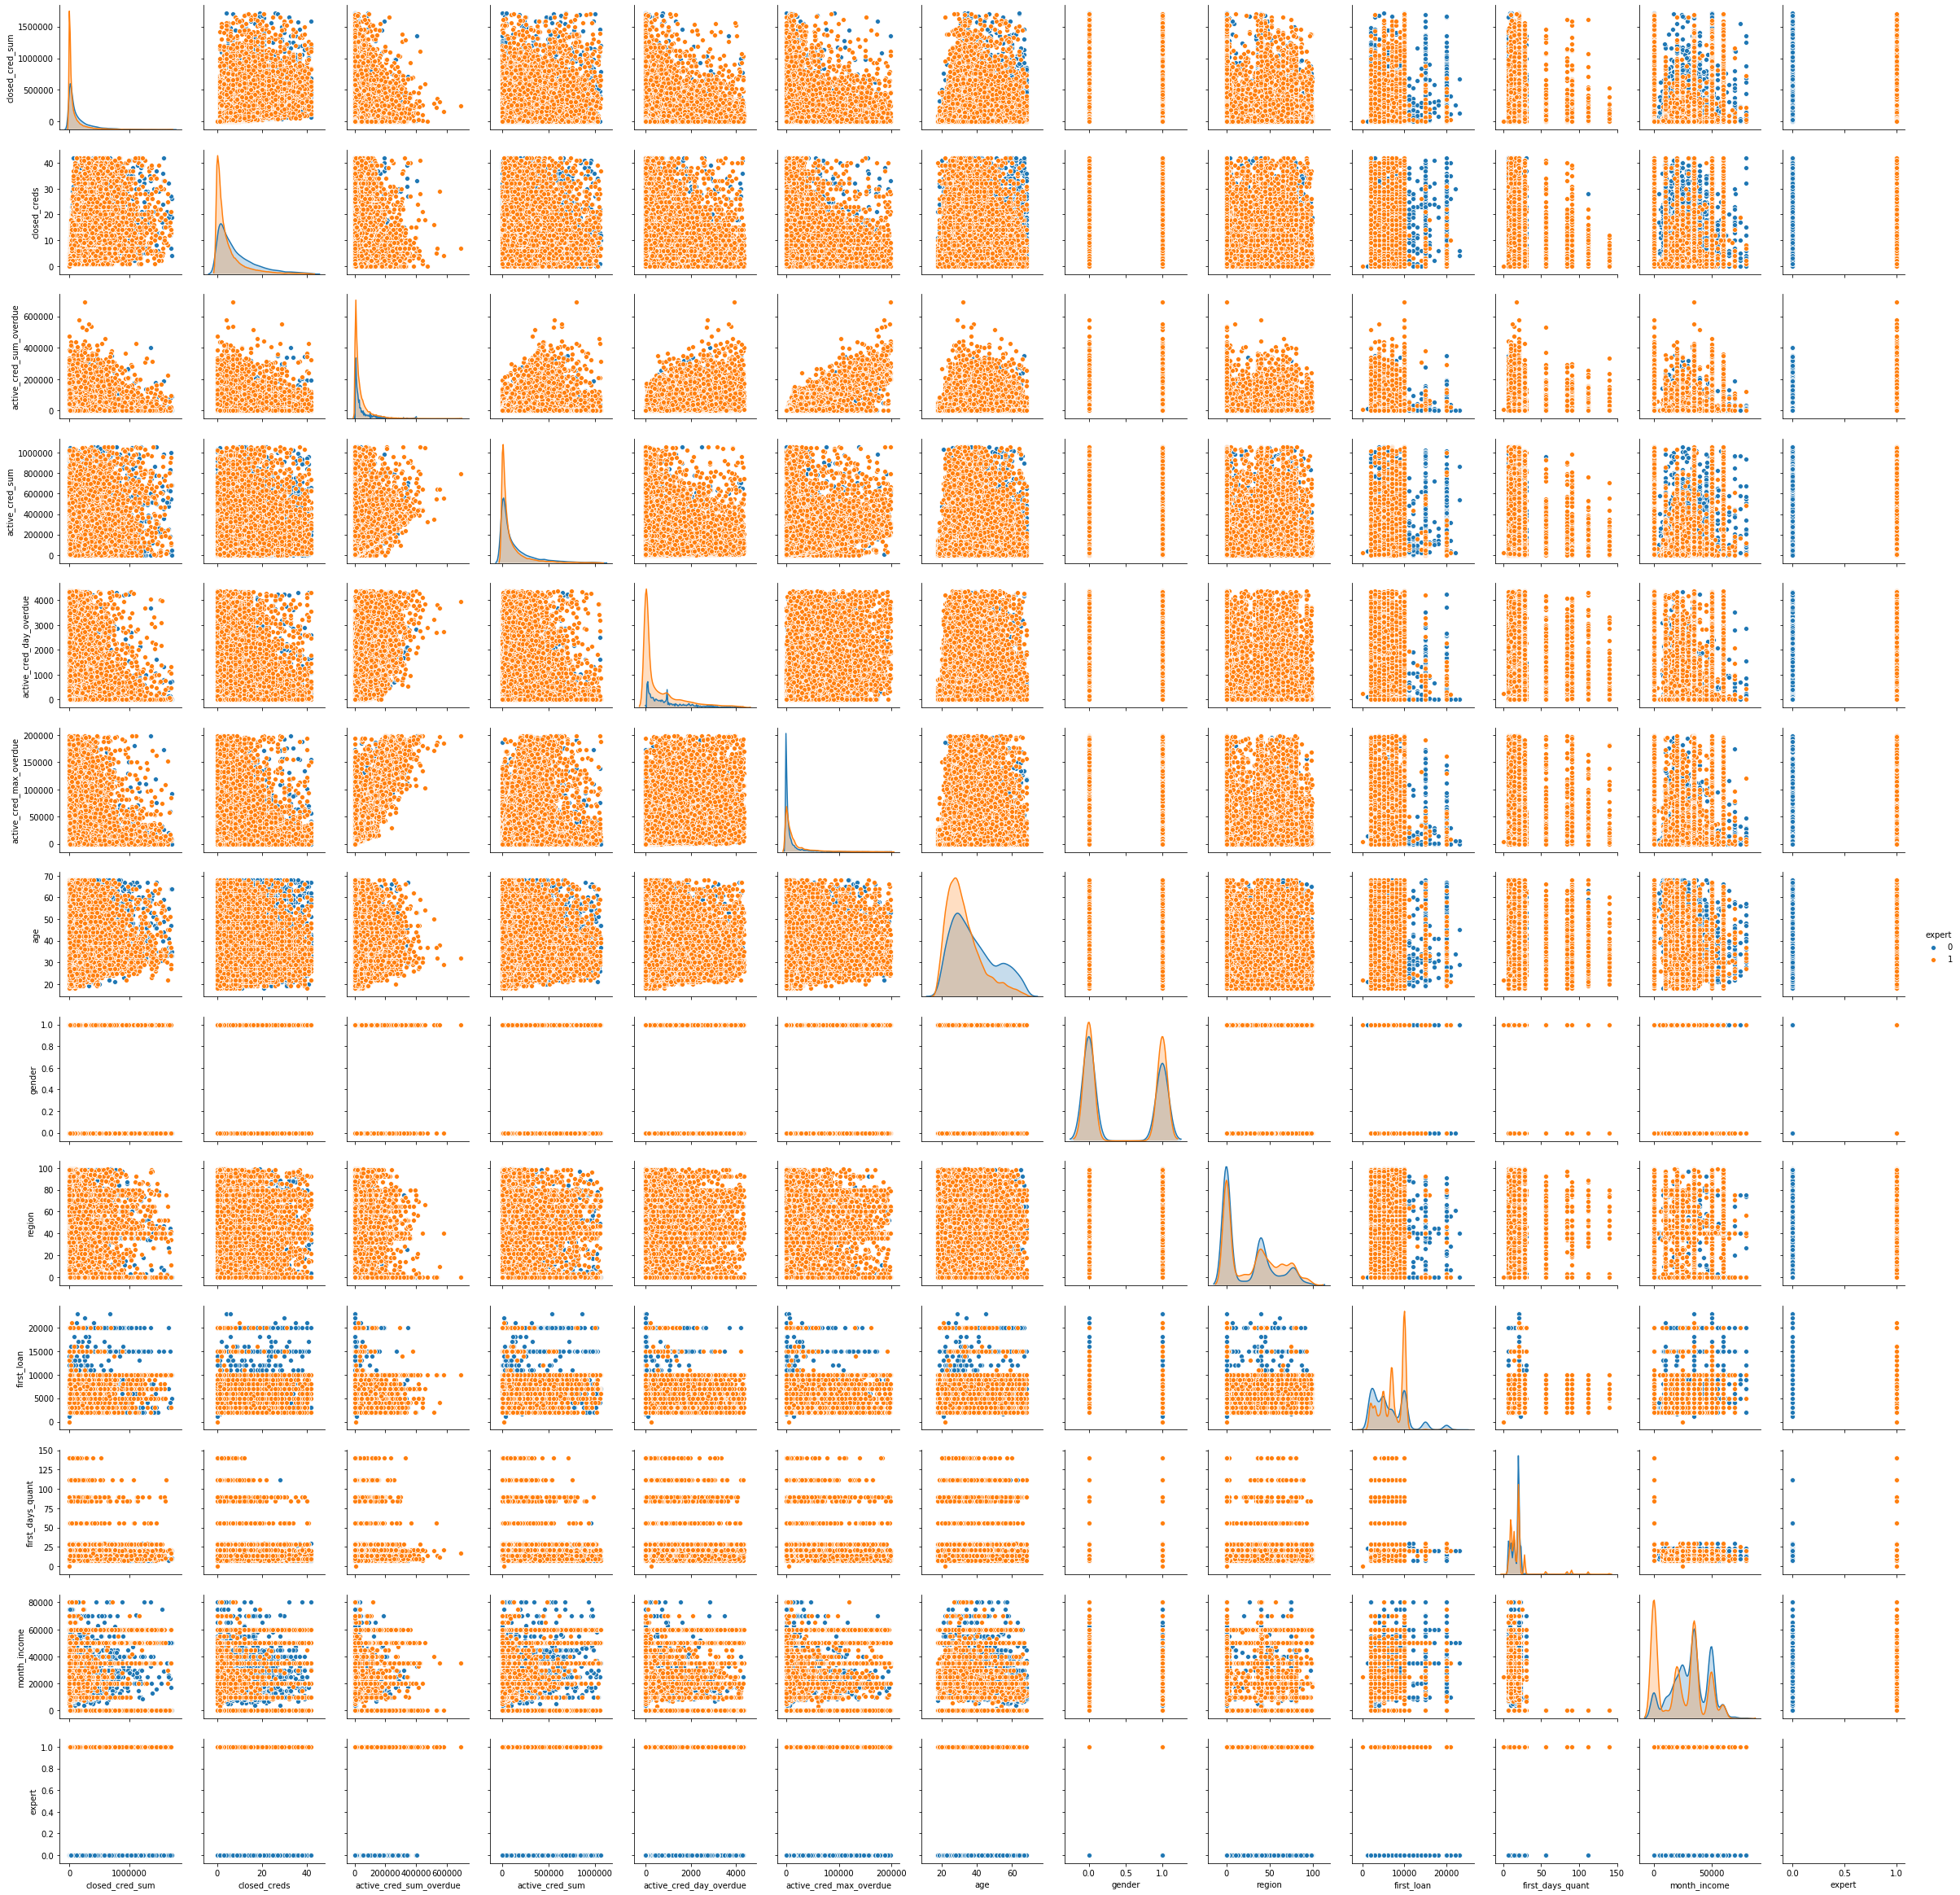

In [39]:
sns.pairplot(df, hue='expert')

In [40]:
# Посмотрим, есть ли смысл оставлять регион в качестве параметра
df_reg = df.groupby(['region']).mean().reset_index()


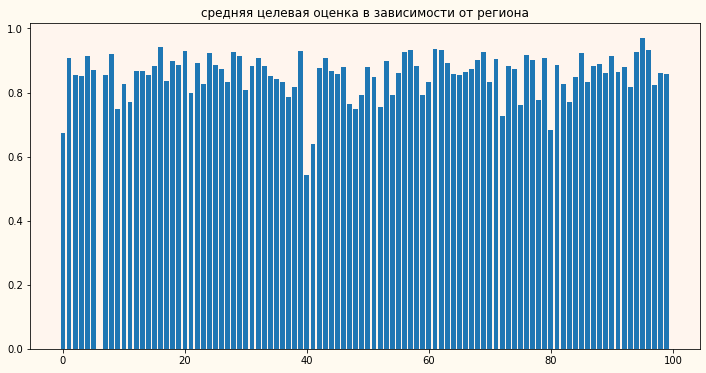

In [41]:
fig, ax = plt.subplots()
ax.bar(df_reg['region'], df_reg['expert'])
ax.set_facecolor('seashell')
ax.set_title('средняя целевая оценка в зависимости от региона')
fig.set_facecolor('floralwhite')
fig.set_figwidth(12)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
plt.show()

In [42]:
# есть просадки по нескольким конкретным значениям параметра регион, но в целом ничего интересного. Однако непонятен смысл самой переменной, 
# соответствует ли она принятой нумерации регионов (видимо нет), почему много значений 0, выкинем её из рассмотрения
# смею предположить, что влияние региона опосредованное. В зависимости от местонахождения меняются доходы и прочие
# характеристики, что тянет за собой и всё остальное

In [43]:
df = df.drop(['region'], axis = 1)
df

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,first_loan,first_days_quant,month_income,expert
0,262187.0,23,0.00,183500.10,0,0.00,58,0,10000.0,23,70000.0,0
2,0.0,0,34193.21,54095.00,3296,15000.00,29,0,3000.0,15,27000.0,1
3,15417.0,1,56669.40,56669.40,1249,30558.84,31,0,10000.0,23,28000.0,0
6,125390.0,5,0.00,339832.00,0,0.00,60,1,2000.0,10,0.0,0
7,157990.0,13,7000.00,60580.00,431,30009.79,54,0,2000.0,23,30000.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
42274,499209.0,15,12210.28,270753.77,137,7399.74,29,0,5000.0,21,0.0,1
42275,0.0,0,42717.37,434739.17,2291,27000.00,27,1,5000.0,21,0.0,1
42276,10980.0,1,0.00,59162.38,0,0.00,52,1,10000.0,21,0.0,1
42277,15176.0,1,0.00,802240.00,0,892.77,26,1,10000.0,14,0.0,1


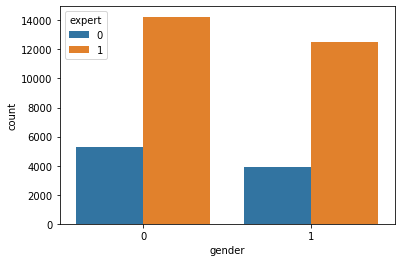

In [44]:
# посмотрим, есть ли что интересное с признаком gender
sns.countplot(x='gender', hue='expert', data=df)

In [45]:
print('процент одобрений (пол 0): ',len(df[(df['gender'] == 0) & (df['expert'] == 0)])/len(df[(df['gender'] == 0)]))
print('процент одобрений (пол 1): ',len(df[(df['gender'] == 1) & (df['expert'] == 0)])/len(df[(df['gender'] == 1)]))

процент одобрений (пол 0):  0.2697314473144731
процент одобрений (пол 1):  0.23814157139382144


cущественных различий не видно. В целом пол 0 чаще подаёт заявки и чаще получает одобрение

# Преобразование переменных

Добавим несколько разумных переменных

In [46]:
# добавим отношение текущей просроченной задолженности к максимальной, чем отношение ниже, 
# тем выше вероятность, что за последнее время финансовое положение клиента улучшилось 
df['overdue_portion'] = df.apply(lambda x: 0 if x.active_cred_max_overdue == 0 else x.active_cred_sum_overdue / x.active_cred_max_overdue, axis=1)

In [47]:
# ежепериодная нагрузка (удельная на единицу времени (дни (?)))
df['power'] = df.apply(lambda x: x.first_loan if x.first_days_quant == 0 else x.first_loan / x.first_days_quant, axis=1)

In [48]:
df

,closed_cred_sum,closed_creds,active_cred_sum_overdue,active_cred_sum,active_cred_day_overdue,active_cred_max_overdue,age,gender,first_loan,first_days_quant,month_income,expert,overdue_portion,power
0,262187.0,23,0.00,183500.10,0,0.00,58,0,10000.0,23,70000.0,0,0.000000,434.782609
2,0.0,0,34193.21,54095.00,3296,15000.00,29,0,3000.0,15,27000.0,1,2.279547,200.000000
3,15417.0,1,56669.40,56669.40,1249,30558.84,31,0,10000.0,23,28000.0,0,1.854436,434.782609
6,125390.0,5,0.00,339832.00,0,0.00,60,1,2000.0,10,0.0,0,0.000000,200.000000
7,157990.0,13,7000.00,60580.00,431,30009.79,54,0,2000.0,23,30000.0,0,0.233257,86.956522
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42274,499209.0,15,12210.28,270753.77,137,7399.74,29,0,5000.0,21,0.0,1,1.650096,238.095238
42275,0.0,0,42717.37,434739.17,2291,27000.00,27,1,5000.0,21,0.0,1,1.582125,238.095238
42276,10980.0,1,0.00,59162.38,0,0.00,52,1,10000.0,21,0.0,1,0.000000,476.190476
42277,15176.0,1,0.00,802240.00,0,892.77,26,1,10000.0,14,0.0,1,0.000000,714.285714


In [49]:
# отношение ежепериодной нагрузки к ежемесячному доходу
df['load'] = df.apply(lambda x: 10 if x.month_income == 0 else x.power / x.month_income, axis=1)

In [50]:
# разобьём датасет на тренировочный/тестовый
X_train, X_test, y_train, y_test = train_test_split(
    df[[col for col in df.columns if col not in ['expert']]], 
    df['expert'], 
    test_size=0.33, 
    random_state=42)

In [51]:
# масштабируем
scale_features_std = StandardScaler() 
X_train = scale_features_std.fit_transform(X_train)

Функция для вывода оценки модели

In [52]:
def confusion_result(X, y, model, revert=False):
    if revert:
        res = sklearn.metrics.confusion_matrix(1 - y, 1 - model.predict(X))
    else:
        res = sklearn.metrics.confusion_matrix(y, model.predict(X))
    # построим confusion matrix
    TN = res[0][0]
    FN = res[1][0]
    TP = res[1][1]
    FP = res[0][1]
    # первая метрика accuracy. Здесь достаточно бесполезна, так как классы не равны (отказов в 3 раза больше)
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    print('accuracy = ', accuracy)
    # precision - количество правильно угаданных отказов к общему количеству предсказанных отказов
    precision = TP / (TP + FP)
    print('precision = ', precision)
    # recall - количество угаданных отказов к реальному кодличеству отказов
    recall = TP / (TP + FN)
    print('recall = ', recall)
    # specificity - количество верно угаданных одобрений к реальному числу одобрений
    specificity = TN / (TN + FP)
    print('specificity = ', specificity)
    # precision(N) - количество верно угаданных одобрений к общему числу предсказанных одобрений
    precision_N = TN / (TN + FN)
    print('precision_N = ', precision_N)
    f1 = 2 * precision * recall / (precision + recall)
    print('F1-score: ', f1)


# Построение первой модели (логистическая регрессия)

In [53]:
# строим логистическую регрессию
clf = LogisticRegression(C=1, random_state=0).fit(X_train, y_train)

In [54]:
# точность на обучающей выборке
clf.score(X_train, y_train)

0.800747198007472

In [55]:
X_test = scale_features_std.fit_transform(X_test)

In [56]:
# точность на отложенной выборке
clf.score(X_test, y_test)

0.8039777515590764

# Оценка модели (логистической регрессии)

In [57]:
# тренировочная выборка для отказов
confusion_result(X_train, y_train, clf, revert=False)

accuracy =  0.800747198007472
precision =  0.827981766267595
recall =  0.9236658284436994
specificity =  0.445682001614205
precision_N =  0.6690089653501333
F1-score:  0.8732104178773311


In [58]:
# отложенная выборка для отказов
confusion_result(X_test, y_test, clf, revert=False)

accuracy =  0.8039777515590764
precision =  0.8345580730761379
recall =  0.9206259851384824
specificity =  0.45676943699731903
precision_N =  0.6590909090909091
F1-score:  0.8754817987152035


In [59]:
# тренировочная выборка для одобрений
confusion_result(X_train, y_train, clf, revert=True)

accuracy =  0.800747198007472
precision =  0.6690089653501333
recall =  0.445682001614205
specificity =  0.9236658284436994
precision_N =  0.827981766267595
F1-score:  0.5349738422786282


In [60]:
# отложенная выборка для одобрений
confusion_result(X_test, y_test, clf, revert=True)

accuracy =  0.8039777515590764
precision =  0.6590909090909091
recall =  0.45676943699731903
specificity =  0.9206259851384824
precision_N =  0.8345580730761379
F1-score:  0.5395882818685669


Как видно, результаты для тренировочной и отложенной выборки практически совпадают. Модель характеризуется чрезмерным количеством отказов: модель одобряет примерно 45% заявок, имеющих в реальности положительный отклик.

[0.        0.        0.        ... 0.9919571 0.9919571 1.       ]
[0.00000000e+00 1.12587255e-04 3.60279216e-03 ... 9.99887413e-01
 1.00000000e+00 1.00000000e+00]


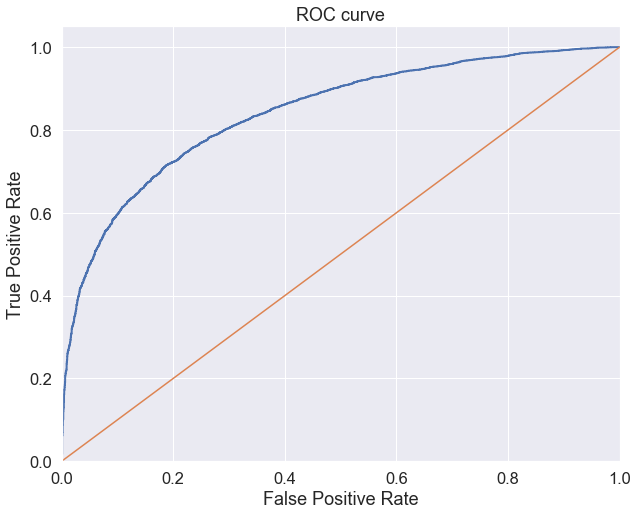

In [61]:
# ROC - кривая
sns.set(font_scale=1.5)
sns.set_color_codes("muted")
plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, clf.predict_proba(X_test)[:,1], pos_label=1)
print(fpr)
print(tpr)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.show()

# Построение второй модели (Решающие деревья)

In [62]:
# строим решающие деревья, добавим минимальную борьбу с переобучением
clf1 = DecisionTreeClassifier(max_depth=7).fit(X_train, y_train)
# точность на обучающей выборке
clf1.score(X_train, y_train)

0.8374014113740141

In [63]:
# точность на отложенной выборке
clf1.score(X_test, y_test)

0.8240350581493342

# Оценка модели (Решающие деревья)

In [64]:
# тренировочная выборка
confusion_result(X_train, y_train, clf1, revert=False)

accuracy =  0.8374014113740141
precision =  0.8766030822286884
recall =  0.9090807488125174
specificity =  0.6303470540758677
precision_N =  0.7058929862617498
F1-score:  0.8925465668120593


In [65]:
# отложенная выборка
confusion_result(X_test, y_test, clf1, revert=False)

accuracy =  0.8240350581493342
precision =  0.8760239096745628
recall =  0.891015537041207
specificity =  0.6246648793565683
precision_N =  0.6581920903954802
F1-score:  0.883456128600134


In [66]:
# тренировочная выборка для одобрений
confusion_result(X_train, y_train, clf1, revert=True)

accuracy =  0.8374014113740141
precision =  0.7058929862617498
recall =  0.6303470540758677
specificity =  0.9090807488125174
precision_N =  0.8766030822286884
F1-score:  0.6659844802592308


In [67]:
# отложенная выборка для одобрений
confusion_result(X_test, y_test, clf1, revert=True)

accuracy =  0.8240350581493342
precision =  0.6581920903954802
recall =  0.6246648793565683
specificity =  0.891015537041207
precision_N =  0.8760239096745628
F1-score:  0.640990371389271
